In [5]:
import glob
import astropy.io.fits as fits
from astropy.time import Time 
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pickle
import pandas as pd
import os
import time

from astropy.wcs import WCS

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
def rms(data):
    """Returns the RMS of the data about the median.
    Args:
        data: a numpy array
    """
    data -= np.median(data)
    return np.sqrt(np.power(data, 2).sum()/len(data))


def clip(data, sigma=3):
    """Remove all values above a threshold from the array.
    Uses iterative clipping at sigma value until nothing more is getting clipped.
    Args:
        data: a numpy array
    """
    raveled = data.ravel()
    median = np.median(raveled)
    std = np.std(raveled)
    newdata = raveled[np.abs(raveled-median) <= sigma*std]
    if len(newdata) and len(newdata) != len(raveled):
        return clip(newdata, sigma)
    else:
        return newdata

In [4]:
def get_lsts(image_list1):
    file_datetimes1 = [pd.to_datetime(os.path.basename(x).split("U")[0], 'raise', format="%Y%m%d%H%M%S")
                          for x in image_list1]

    times = Time(file_datetimes1)
    file_lst1 = [y.sidereal_time('apparent', 6.868889).deg for y in times]
    return file_lst1
def get_lst(image_name):
    return Time(pd.to_datetime(os.path.basename(image_name).split("U")[0],
                        'raise', format="%Y%m%d%H%M%S")).sidereal_time('apparent', 6.868889).deg


In [8]:
# create list of image path/*.fits with glob
# image_list = sorted(glob.glob("all_sky_fits/*.fits"))
image_list = sorted(glob.glob("/data/20180122_179/*.fits"))
print len(image_list)
# or read from file

428


In [7]:
image_list1 = sorted(glob.glob("201609051647_16SB_beam/*.fits"))
list_rms1 = []

for i in image_list1[::10]:
    data, f=fits.getdata(i,header=True)
    list_rms.append(rms(clip(data[0,0,:,:][np.isfinite(data[0,0,:,:])] )))

# get lst from filenames 
file_lst1 = get_lsts(image_list1[::10])

ValueError: No time format was given, and the input is not unique

In [ ]:
plt.figure()
plt.plot(list_rms1,".")

In [6]:
data = {}
obs_dates = [x.split("_")[1].split(".")[0] for x in glob.glob("*_*.txt") ]

for i in obs_dates:
    data[i] = {}

for i in range(len(glob.glob("*_*.txt"))):
    t1 = time.time()
    with open(glob.glob("*_*.txt")[i]) as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    length = len(content)
    #check if key entry exists and dont overwrite! 
    if "filename" in data[obs_dates[i]]:
        data[obs_dates[i]]["filename"] = np.append(data[obs_dates[i]]["filename"], content)
        data[obs_dates[i]]["lst"] = np.append(data[obs_dates[i]]["lst"], get_lsts(content))
    else:
        data[obs_dates[i]]["filename"] = content
        data[obs_dates[i]]["lst"] = get_lsts(content)
    t2 = time.time()
    print length, "files in", t1-t2, "seconds ", float(length)/(t1-t2), "fps"

23410 files in -136.892773151 seconds  -171.009757937 fps
21916 files in -119.555560112 seconds  -183.312260672 fps
12550 files in -68.4328098297 seconds  -183.391563655 fps
523 files in -2.87133598328 seconds  -182.145176686 fps
49161 files in -267.481988907 seconds  -183.791814174 fps
10202 files in -55.4302179813 seconds  -184.051233633 fps
51192 files in -278.454952002 seconds  -183.843022478 fps
20846 files in -113.203560829 seconds  -184.146150945 fps
55632 files in -301.673892021 seconds  -184.411052701 fps
10055 files in -54.8698060513 seconds  -183.251969045 fps


In [54]:
test = {}
test["filename"] = {}
test["filename"]["data"] = [9,99,9,9]
if "data" in test["filename"]:
    test["filename"]["data"] = np.append(test["filename"]["data"], [1,1,1,1])
else:
    test["filename"]["data"] = [1,1,1,1] 

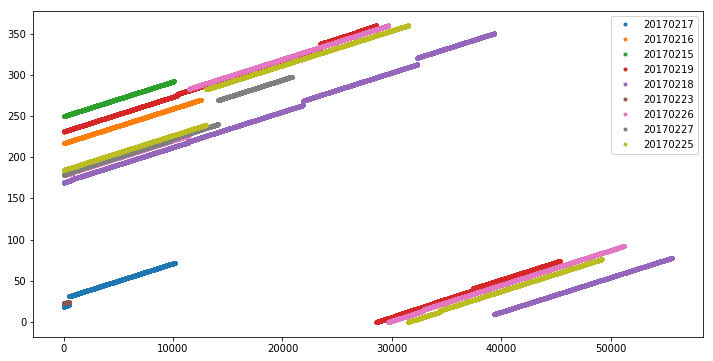

In [7]:
plt.figure(figsize=(12,6))
for i in data.keys():
    plt.plot(data[i]["lst"], ".", label=i)
plt.legend()

In [10]:

for i in data.keys():
    print i
    data[i]["rms"] = np.array([])
    for imagefile in data[i]["filename"]:
        try:
            img, f=fits.getdata(imagefile,header=True)
            data[i]["rms"] = np.append(data[i]["rms"],
                                                  rms(clip(img[0,0,:,:][np.isfinite(img[0,0,:,:])] )))

        except IOError:
            imagefile = '/mnt/ads001/201702/'+os.path.basename(imagefile)
            img, f=fits.getdata(imagefile,header=True)
            data[i]["rms"] = np.append(data[i]["rms"],
                                                  rms(clip(img[0,0,:,:][np.isfinite(img[0,0,:,:])] )))

20170217


KeyboardInterrupt: 

/afhome/kuiack/venv/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  after removing the cwd from sys.path.
/afhome/kuiack/venv/lib/python2.7/site-packages/ipykernel_launcher.py:15: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  from ipykernel import kernelapp as app
/afhome/kuiack/venv/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


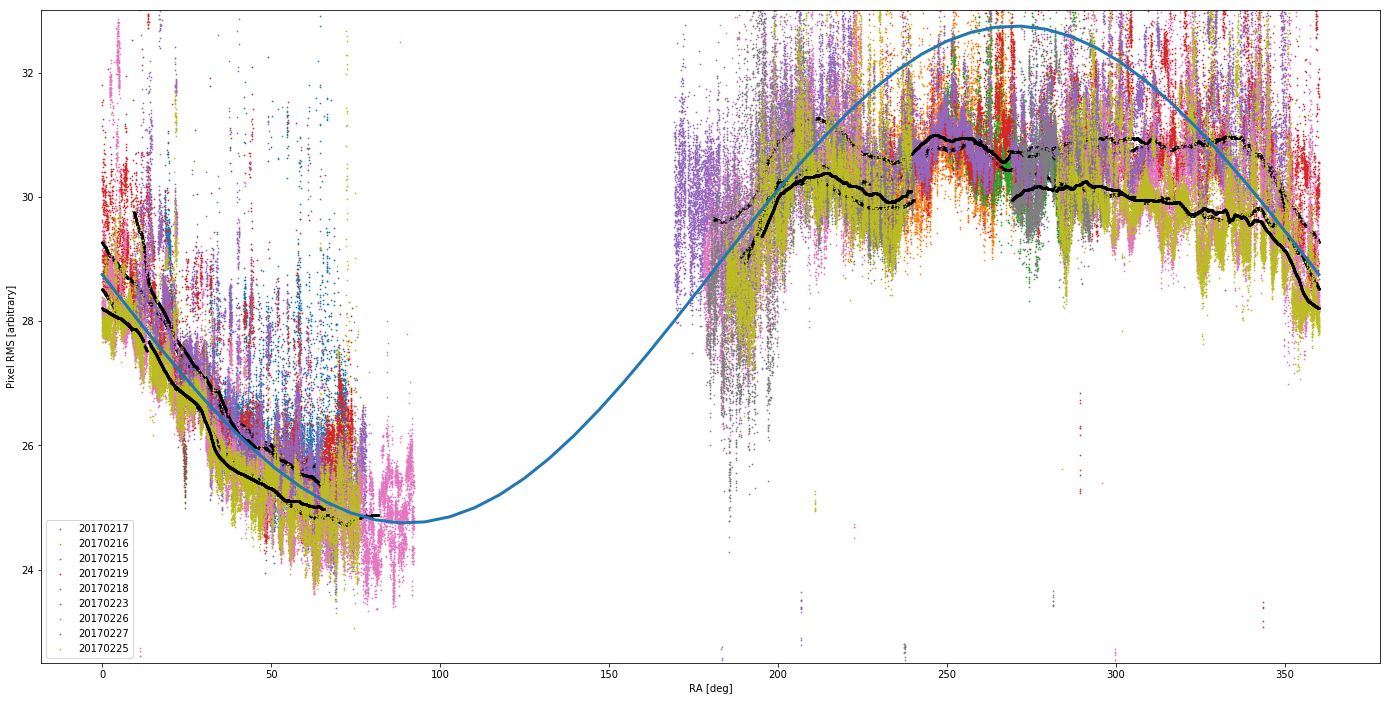

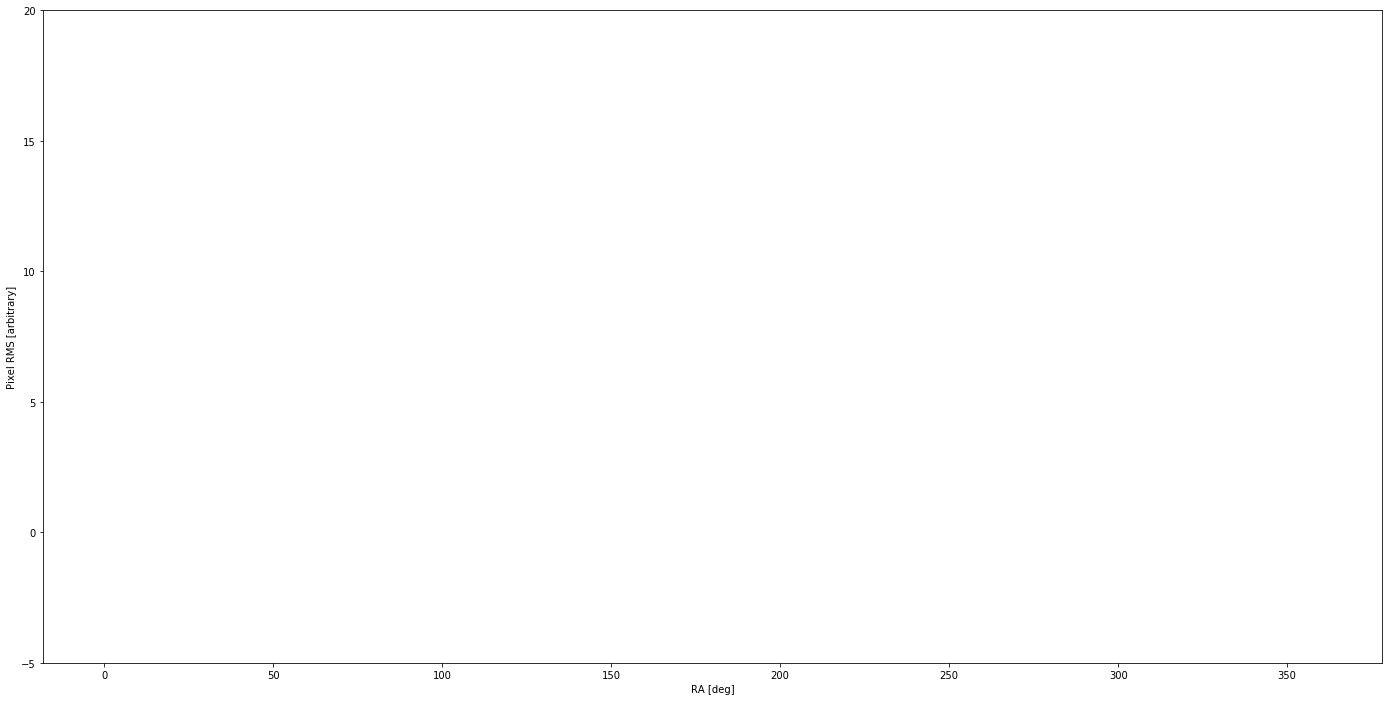

In [167]:
plt.figure(figsize=(24,12))
for i in data.keys():
    plt.scatter(data[i]["lst"],data[i]["rms"],s=.5, label=i)
    plt.scatter(data[i]["lst"], pd.rolling_median(data[i]["rms"], 5000, center=True),s=.5, color="black")
    #print data[i]["filename"][0], data[i]["filename"][-1]
    #print float(len(data[i]["rms"][(data[i]["rms"] > 30)]))/len(data[i]["rms"])
plt.legend()
plt.plot(np.linspace(0,360),-4*np.sin(np.linspace(-360,0)*2*np.pi/360)+28.75, lw=3)
plt.ylim([22.5,33])
plt.ylabel("Pixel RMS [arbitrary]")
plt.xlabel("RA [deg]")

plt.figure(figsize=(24,12))
for i in data.keys():
    plt.scatter(data[i]["lst"], pd.rolling_median(data[i]["rms"], window, center=True),s=.5)
    #print data[i]["filename"][0], data[i]["filename"][-1]
    #print float(len(data[i]["rms"][(data[i]["rms"] > 30)]))/len(data[i]["rms"])
plt.legend()
plt.plot(np.linspace(0,360),-4*np.sin(np.linspace(-360,0)*2*np.pi/360)+28.75, lw=3)
plt.ylim([-5,20])
plt.ylabel("Pixel RMS [arbitrary]")
plt.xlabel("RA [deg]")



20170227


/afhome/kuiack/venv/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  
/afhome/kuiack/venv/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  # Remove the CWD from sys.path while we load stuff.


(-5, 20)

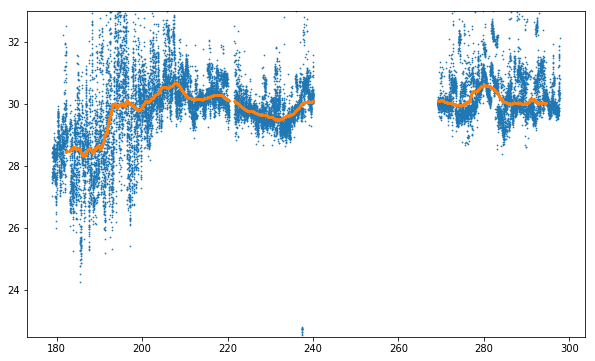

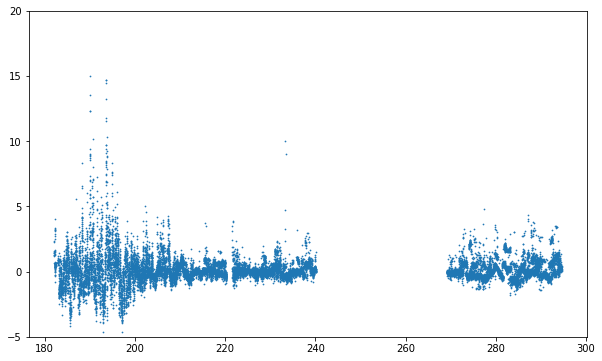

In [166]:
window = 1500
#for i in data.keys():
i = data.keys()[7]
print i
plt.scatter(data[i]["lst"],data[i]["rms"],s=.5, label=i)
plt.scatter(data[i]["lst"], pd.rolling_median(data[i]["rms"], window, center=True),s=.5)
plt.ylim([22.5,33])

plt.figure()
plt.scatter(data[i]["lst"], data[i]["rms"]-pd.rolling_median(data[i]["rms"], window, center=True),s=.5)
plt.ylim([-5,20])
#plt.xlim([218,220])


In [147]:
data['20170227']["lst"] = np.array(data['20170227']["lst"], dtype=np.float)
data['20170227']["rms"] = np.array(data['20170227']["rms"], dtype=np.float)


/data/201702/20170227033903UTC_S307.5_I16x1_W6_A1.5.fits /data/201702/20170227033904UTC_S307.5_I16x1_W6_A1.5.fits /data/201702/20170227033905UTC_S307.5_I16x1_W6_A1.5.fits /data/201702/20170227033906UTC_S307.5_I16x1_W6_A1.5.fits /data/201702/20170227033907UTC_S307.5_I16x1_W6_A1.5.fits /data/201702/20170227033908UTC_S307.5_I16x1_W6_A1.5.fits /data/201702/20170227033909UTC_S307.5_I16x1_W6_A1.5.fits /data/201702/20170227033910UTC_S307.5_I16x1_W6_A1.5.fits /data/201702/20170227033911UTC_S307.5_I16x1_W6_A1.5.fits /data/201702/20170227033912UTC_S307.5_I16x1_W6_A1.5.fits /data/201702/20170227033913UTC_S307.5_I16x1_W6_A1.5.fits /data/201702/20170227033914UTC_S307.5_I16x1_W6_A1.5.fits /data/201702/20170227033915UTC_S307.5_I16x1_W6_A1.5.fits /data/201702/20170227033916UTC_S307.5_I16x1_W6_A1.5.fits /data/201702/20170227033917UTC_S307.5_I16x1_W6_A1.5.fits /data/201702/20170227033918UTC_S307.5_I16x1_W6_A1.5.fits /data/201702/20170227033919UTC_S307.5_I16x1_W6_A1.5.fits /data/201702/20170227033920UTC_

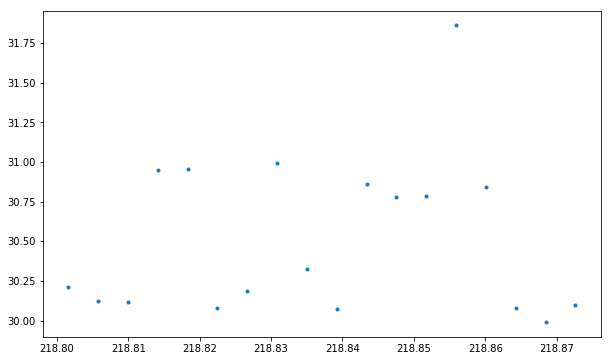

In [162]:
#index = np.array((np.array(data['20170227']["lst"]) > 218) & (np.array(data['20170227']["lst"]) < 220), dtype=bool)
x = np.array(data['20170227']["lst"]) > 218.8
y = np.array(data['20170227']["lst"]) < 218.875

index = [a and b for a, b in zip(x, y)]

index = (np.where(index)[0])
print " ".join(np.array(data['20170227']["filename"])[index])
plt.plot(data['20170227']["lst"][index], data['20170227']["rms"][index], ".")

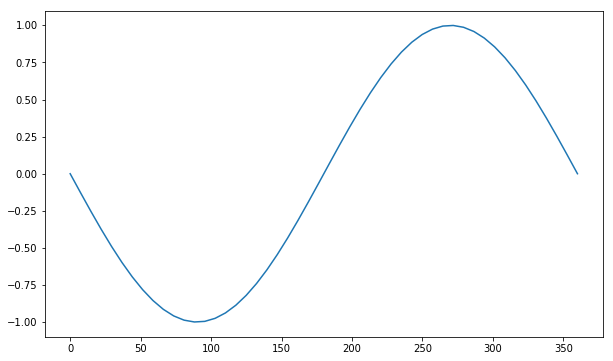

In [37]:
plt.plot(np.linspace(0,360),-np.sin(np.linspace(-360,0)*2*np.pi/360))

In [ ]:
print "hi"

In [ ]:
plt.figure(figsize=(12,6))
for i in data.keys():
    plt.plot(data[i]["lst"],data[i]["rms"], ".", label=i)
    
plt.ylim([0,100])
plt.legend()

In [ ]:
import pickle

with open('201702_data.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [17]:
img, f=fits.getdata('/mnt/ads001/201702/'+os.path.basename('data/201702/20170217145543UTC_S307.5_I16x1_W6_A1.5.fits'),header=True)

In [11]:
data = load_obj('201702_data.pickle')


In [10]:
data['20170217'].keys()

['rms', 'lst', 'filename']

In [6]:
image_list = sorted(glob.glob("/data/201801_SB179/*.fits"))[-1000:-900]



In [11]:
wcs = WCS(image_list[0])

print wcs

WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : 62.231182915385901  52.915122494999999  34960936.0  1.0  
CRPIX : 513.0  513.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.111905890509415  0.111905890509415  190734.875  1.0  
NAXIS : 1024  1024  1  1


TypeError: get_transform() takes exactly 1 argument (2 given)

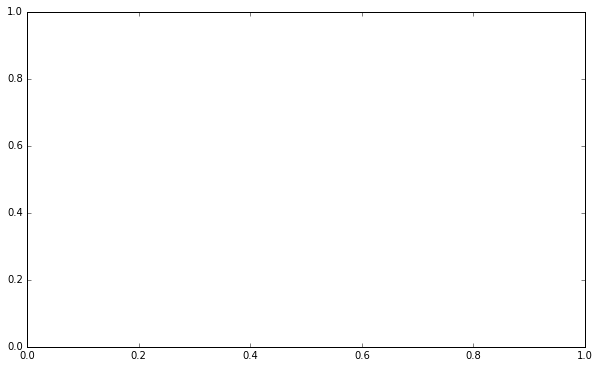

In [18]:
plt.gca().get_transform('world')

TypeError: get_transform() takes exactly 1 argument (2 given)

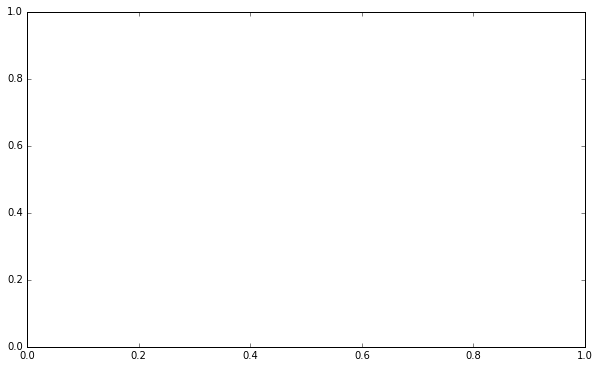

In [17]:

fig = plt.figure()
wcs = WCS(image_list[0])
# ax = fig.add_subplot(111, projection=wcs)
data, f=fits.getdata(image_list[0],header=True)
plt.scatter(300, 85, marker='+', s=10, transform=)
ax.imshow(data)

In [72]:

image_cube = np.zeros([1024,1024,len(image_list)])
for i in range(len(image_list)):
    data, f=fits.getdata(image_list[i],header=True)
#     image_wcs = WCS(images.iloc[i])
    image_cube[:,:,i] = data
    

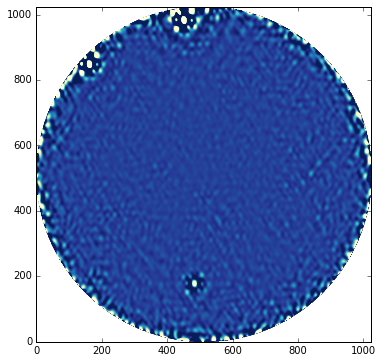

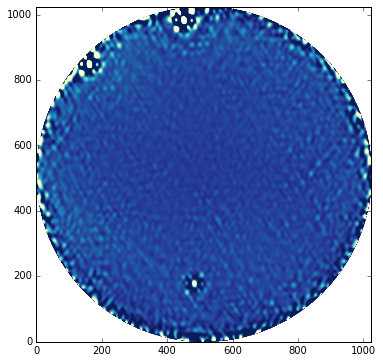

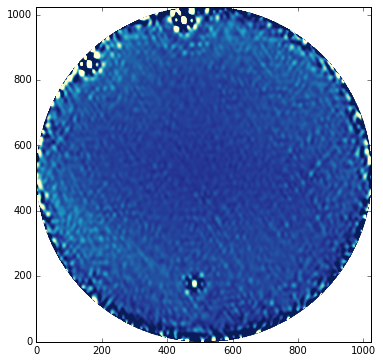

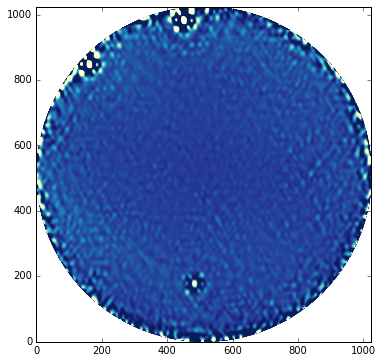

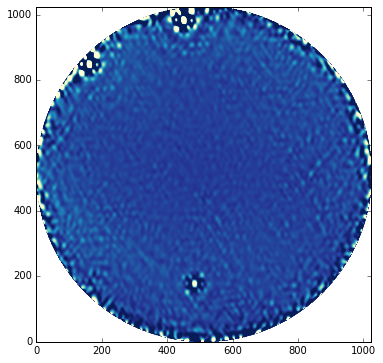

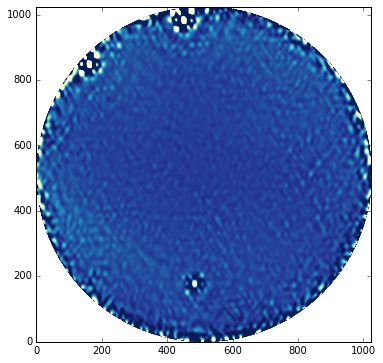

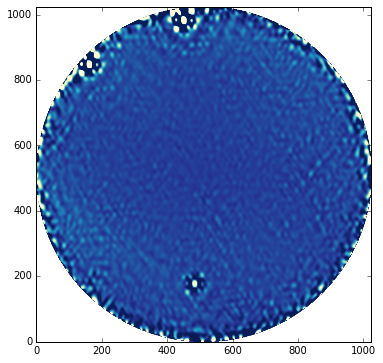

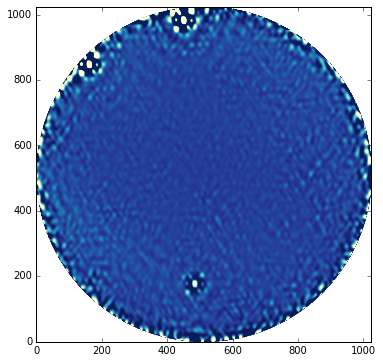

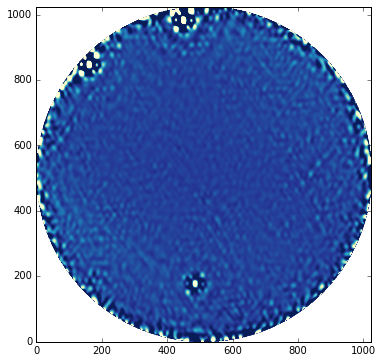

In [73]:
for i in [2,4,8,15,20,25,30,50,100]:
    plt.figure()
    plt.imshow(np.average(image_cube[:,:,:i],axis=2, weights=[1./np.nanstd(image_cube[:,:,x]) for x in np.arange(i)]), origin="lower",vmin=-20,vmax=100, cmap="YlGnBu_r")
    plt.show()

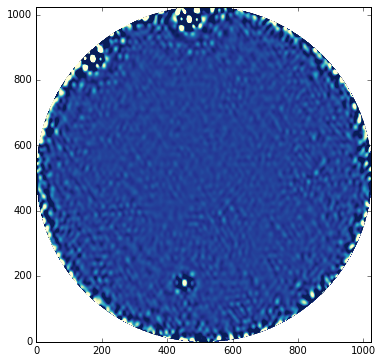

In [66]:
plt.figure()
plt.imshow(np.average(image_cube[:,:,[0,1,2,3,5,7,9]],axis=2, 
                      weights=[1./np.nanstd(image_cube[:,:,x]) for x in [0,1,2,3,5,7,9]]),
           origin="lower",vmin=-20,vmax=100, cmap="YlGnBu_r")

In [45]:
[1./np.nanstd(image_cube[:,:,x]) for x in np.arange(i)]

[0.034972560855847448,
 0.035357954265683368,
 0.03505140272329569,
 7.0542674095243909e-10,
 6.8653573401244893e-10,
 0.032210727035614443,
 0.032521950336749567,
 3.0596618964206764e-10,
 0.033185400908904129,
 0.042767159089262069,
 0.029706303798245487,
 0.031640750481588042,
 0.034890081086159243,
 6.7807331464414132e-10,
 0.0288657267369937,
 0.03274355910394814,
 6.8041904807895142e-10,
 6.8809292807895479e-10,
 0.0316080599977,
 0.0213172757902414,
 0.021140133855032682,
 6.5695595466564362e-10,
 6.7371934291950635e-10,
 0.023649857505983966,
 0.019502325997733157,
 6.4617505115674623e-10,
 0.02169221781218076,
 0.021272636958915302,
 6.8290508047397002e-10,
 0.023348653504018668,
 0.02138296427308839,
 0.020806831575330444,
 0.020793847243890377,
 0.016806097366845501,
 0.01683636937081405,
 0.016017815023550694,
 6.5308772621552461e-10,
 0.014875062812724526,
 0.014197152821325299,
 0.012033372947494986,
 5.4188924352991903e-10,
 5.3168231019859947e-10,
 0.013328026844162944,

In [68]:
for i in np.arange(10):
    plt.figure()
    plt.imshow(image_cube[:,:,i], origin="lower",vmin=-20,vmax=100, cmap="YlGnBu_r")

IndexError: index 0 is out of bounds for axis 2 with size 0